# Necessary Steps

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -U ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.8/921.8 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [3]:
import json
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import shutil
from random import choice
import re
import csv
import pandas as pd
import glob
import math
import geopandas as gpd
from shapely.geometry import shape
from shapely.geometry import Polygon
from ultralytics import YOLO
from PIL import Image
import requests
import time
import os
from ultralytics import YOLO
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.util import img_as_ubyte
from shapely.geometry import box

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
cd /content/drive/MyDrive/Pond/YoLoV11/Pond_Zoom17

/content/drive/MyDrive/Pond/YoLoV11/Pond_Zoom17


In [5]:
pwd = os.getcwd()
pwd

'/content/drive/MyDrive/Pond/YoLoV11/Pond_Zoom17'

# Download Data for Inference

In [7]:
pwd

'/content/drive/MyDrive/Pond/YoLoV11/Pond_Zoom17'

Get Bounding boxes automatically from GeoJSON instead of manually drawing on GEE

In [16]:
gdf = gpd.read_file("Koraput.geojson")


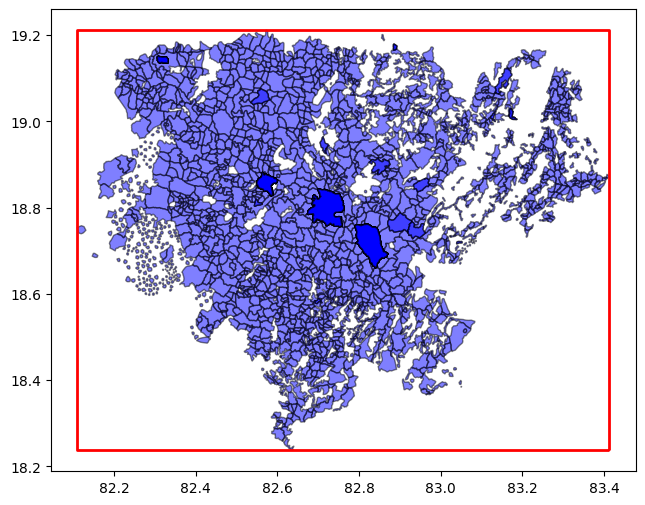

In [17]:
# Compute the bounding box
minx, miny, maxx, maxy = gdf.total_bounds

# Create a bounding box polygon
bounding_box = gpd.GeoDataFrame(geometry=[box(minx, miny, maxx, maxy)], crs=gdf.crs)

# Plot the geometry and the updated bounding box
fig, ax = plt.subplots(figsize=(10, 6))
gdf.plot(ax=ax, color="blue", alpha=0.5, edgecolor="black")
bounding_box.plot(ax=ax, edgecolor="red", facecolor="none", linewidth=2)

plt.show()

In [18]:
# Get the bounding box coordinates
minx, miny, maxx, maxy = gdf.total_bounds

# Define bounding box points
topLeft = [minx, maxy]
topRight = [maxx, maxy]
bottomRight = [maxx, miny]
bottomLeft = [minx, miny]

# Print the coordinates
print(f"topLeft = {topLeft}")
print(f"topRight = {topRight}")
print(f"bottomRight = {bottomRight}")
print(f"bottomLeft = {bottomLeft}")

topLeft = [82.1103416631179, 19.211269993726535]
topRight = [83.4128493198342, 19.211269993726535]
bottomRight = [83.4128493198342, 18.23733756956615]
bottomLeft = [82.1103416631179, 18.23733756956615]


In [19]:
topLeft

[82.1103416631179, 19.211269993726535]

NOT NEEDED ANYMORE - Give coordinated of the bounding box drawn on GEE

In [ ]:
"""
#coords for the bounding box (boipariguda)
topLeft = [82.07347488402685,18.57110542069261]
topRight = [82.60081863402685,18.57110542069261]
bottomRight = [82.60081863402685,18.9572939770273]
bottomLeft = [82.07347488402685,18.9572939770273]
"""

Zoom Level and folder name, where the output (image tiles) will be saved

In [ ]:
zoom_level = 17       # Zoom level
output_folder = "/content/drive/MyDrive/Pond/Data_Download/Final/Zoom17/Boipariguda"

In [ ]:
def deg2num(lat_deg, lon_deg, zoom):
    lat_rad = math.radians(lat_deg)
    n = 2.0 ** zoom
    xtile = int((lon_deg + 180.0) / 360.0 * n)
    ytile = int((1.0 - math.log(math.tan(lat_rad) + (1 / math.cos(lat_rad))) / math.pi) / 2.0 * n)
    return (xtile, ytile)

def getCoords(zoomLevel):
    topleft = deg2num(topLeft[1], topLeft[0], zoomLevel)  # (c,b)
    topright = deg2num(topRight[1], topRight[0], zoomLevel)  # (a,b)
    bottomright = deg2num(bottomRight[1], bottomRight[0], zoomLevel)  # (a,d)
    bottomleft = deg2num(bottomLeft[1], bottomLeft[0], zoomLevel)  # (c,d)
    xmin = min(topleft[0], topright[0], bottomleft[0], bottomright[0])
    xmax = max(topleft[0], topright[0], bottomleft[0], bottomright[0])
    ymin = min(topleft[1], topright[1], bottomleft[1], bottomright[1])
    ymax = max(topleft[1], topright[1], bottomleft[1], bottomright[1])
    return (xmin, xmax, ymin, ymax)

def download_map_tiles(base_url, output_folder, zoom_level, scale):
    # Ensure output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Get start time
    start_time = time.time()

    # Iterate over each tile within the specified range
    xmin, xmax, ymin, ymax = getCoords(zoom_level)
    for x in range(xmin, xmax + 1):
        for y in range(ymin, ymax + 1):
            # Construct the URL for the current tile with scale=3 for 640x640
            tile_url = f"{base_url}&x={x}&y={y}&z={zoom_level}&scale={scale}"
            print(tile_url)
            try:
                # Send HTTP GET request to fetch the tile
                response = requests.get(tile_url)

                # Check if request was successful (status code 200)
                if response.status_code == 200:
                    # Save the tile image to a file in the output folder
                    filename = f"tile_{zoom_level}_{x}_{y}.png"
                    filepath = os.path.join(output_folder, filename)
                    with open(filepath, "wb") as f:
                        f.write(response.content)
                    print(f"Downloaded: {filename}")
                else:
                    print(f"Failed to download tile ({x}, {y}), HTTP status code: {response.status_code}")

            except Exception as e:
                print(f"Error downloading tile ({x}, {y}): {e}")

    # Get end time
    end_time = time.time()

    # Print the total execution time
    print(f"Total time taken: {end_time - start_time} seconds")

In [ ]:
base_url = "https://mt1.google.com/vt/lyrs=s"
scale = 1           # scale of 1 = 256*256 dimensional image

if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"Created the folder: {output_folder}")
else:
    print(f"The folder already exists: {output_folder}")

In [ ]:
download_map_tiles(base_url, output_folder, zoom_level, scale)

# SAVE PREDICTIONS IN CSV

In [ ]:
pwd

'/content/drive/MyDrive/Pond/YoLoV11/Pond_Zoom17'

Initialize model and parameters

In [ ]:
model_path = "FarmPonds_results/NoHypeFile-50epochs_batch2_dim256/weights/best.pt"

image_dir = "/content/drive/MyDrive/Pond/Data_Download/temp"

csv_file = "TRY.csv"

zoom = 17

entropy_threshold = 2.5

In [ ]:
conf_thresholds = {
    'Dry': 0.75,
    'Wet': 0.6
}

class_names = ['Dry', 'Wet']


class_abbreviations = {'Dry': 'D', 'Wet': 'W'}

Function to calculate entropy

In [ ]:
def get_entropy(img, mask):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)  # Convert to grayscale
    mask[mask > 0] = 1  # Ensure mask is binary
    if mask.shape[:2] != img_gray.shape:
        print("Mask shape does not match image shape")
        return 0

    # Normalize the grayscale image to [0, 1]
    img_gray = (img_gray - img_gray.min()) / (img_gray.max() - img_gray.min())

    # Convert to uint8 after normalization
    img_gray = img_as_ubyte(img_gray)

    ent = entropy(img_gray.copy(), disk(5), mask=mask)
    ent = ent[ent > 5.2]
    if np.sum(mask) > 0:
        ent = np.sum(ent) / np.sum(mask)  # Average entropy based on the mask area
    else:
        ent = 0
    return ent

Load the model

In [ ]:
my_new_model = YOLO(model_path)

Functions to save segmented/detected object in a CSV

In [ ]:
def process_image(image_path, conf_thresholds):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Unable to load image {image_path}")
        return None, None, None, None, None

    results = my_new_model.predict(img)

    polygons = []
    pred_classes = []
    conf_scores = []
    entropies = []

    if results[0].masks is not None:
        for i, (polygon, cls, conf) in enumerate(zip(results[0].masks.xy, results[0].boxes.cls.cpu().numpy(), results[0].boxes.conf.cpu().numpy())):
            class_name = class_names[int(cls)]
            if conf >= conf_thresholds[class_name]:
                polygons.append(polygon)
                pred_classes.append(class_name)
                conf_scores.append(conf)

                if class_name == 'Wet':  # Only compute entropy for Wet class
                    predicted_mask = results[0].masks.data.cpu().numpy()[i].astype(np.uint8)  # Convert to uint8
                    entropy_value = get_entropy(img, predicted_mask)  # Calculate entropy for the masked region
                    entropies.append(entropy_value)
                    print(f"Entropy for {class_name}: {entropy_value:.2f}")
                else:
                    entropies.append(None)  # Skip entropy calculation for Dry class

    return image_path, len(polygons), polygons, pred_classes, conf_scores, entropies


def extract_xtile_ytile(image_path):
    try:
        basename = os.path.basename(image_path)
        parts = basename.split('_')
        if len(parts) >= 4:
            xtile = int(parts[2])
            ytile = int(parts[3].split('.')[0].split()[0])
            return xtile, ytile
        else:
            raise ValueError("Filename does not contain valid tile coordinates")
    except Exception as e:
        raise ValueError(f"Filename {image_path} does not contain valid tile coordinates: {e}")

def tile_corners_to_latlon(xtile, ytile, zoom):
    n = 2.0 ** zoom
    lon_deg = xtile / n * 360.0 - 180.0
    lat_rad_nw = math.atan(math.sinh(math.pi * (1 - 2 * (ytile / n))))
    lat_deg_nw = math.degrees(lat_rad_nw)

    lat_rad_se = math.atan(math.sinh(math.pi * (1 - 2 * ((ytile + 1) / n))))
    lat_deg_se = math.degrees(lat_rad_se)

    lat_deg_nw = max(min(lat_deg_nw, 85.0511), -85.0511)
    lat_deg_se = max(min(lat_deg_se, 85.0511), -85.0511)

    top_left = (lat_deg_nw, lon_deg)
    top_right = (lat_deg_nw, lon_deg + (360.0 / n))
    bottom_right = (lat_deg_se, lon_deg + (360.0 / n))
    bottom_left = (lat_deg_se, lon_deg)

    return top_left, top_right, bottom_left, bottom_right

def calculate_tile_center(top_left, top_right, bottom_left, bottom_right):
    center_lat = (top_left[0] + bottom_left[0]) / 2
    center_lon = (top_left[1] + top_right[1]) / 2
    return (center_lat, center_lon)

def visualize_polygons(image_path, polygons, pred_classes, conf_scores):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Unable to load image {image_path}")
        return

    if len(polygons) == 0:
        print(f"No predictions for image {image_path}, not saving.")
        return

    for i, polygon in enumerate(polygons):
        polygon = np.array(polygon, dtype=np.int32)
        polygon = polygon.reshape((-1, 1, 2))
        cv2.polylines(img, [polygon], isClosed=True, color=(0, 255, 0), thickness=2)

        # Calculate the centroid of the polygon for placing the text
        M = cv2.moments(polygon)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            cX, cY = polygon[0][0]

        # Put class abbreviation and confidence score text on the image
        class_abbr = class_abbreviations[pred_classes[i]]
        conf_text = f"{class_abbr}: {conf_scores[i]:.2f}"
        cv2.putText(img, conf_text, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    output_path = os.path.join(annotated_images_dir, os.path.basename(image_path))
    cv2.imwrite(output_path, img)
    print(f"Annotated image saved to {output_path}")

Predictions

In [ ]:
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

In [ ]:
len(image_files)

56

In [ ]:
max_vertices = 0
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

# First Pass: Find max vertices in polygons
for image_path in image_files:
    _, _, polygons, _, _, _ = process_image(image_path, conf_thresholds)
    if polygons:
        max_vertices = max(max_vertices, max(len(polygon) for polygon in polygons))

# Create dynamic column headers for X/Y coordinates
coordinate_headers = []
for i in range(1, max_vertices + 1):
    coordinate_headers.append(f"X_{i}")
    coordinate_headers.append(f"Y_{i}")

# Full header row
header = ["Image Path", "Predicted Class", "Center Latitude", "Center Longitude",
          "Top Left Latitude", "Top Left Longitude", "Top Right Latitude", "Top Right Longitude",
          "Bottom Left Latitude", "Bottom Left Longitude", "Bottom Right Latitude", "Bottom Right Longitude"] + coordinate_headers

# Process and save to CSV
start_time = time.time()

with open(csv_file, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(header)  # Write dynamic header row

    for image_path in image_files:
        try:
            image_path, num_polygons, polygons, pred_classes, conf_scores, entropies = process_image(image_path, conf_thresholds)
            if image_path is None:
                continue

            xtile, ytile = extract_xtile_ytile(image_path)
            top_left, top_right, bottom_left, bottom_right = tile_corners_to_latlon(xtile, ytile, zoom)
            latitude, longitude = calculate_tile_center(top_left, top_right, bottom_left, bottom_right)

            for pred_class, polygon, entropy_value in zip(pred_classes, polygons, entropies):
                if entropy_value is None or entropy_value > entropy_threshold:
                    print(f"Skipped {pred_class} due to high entropy: {entropy_value if entropy_value is not None else 'None'}")
                    continue

                row = [image_path, pred_class, latitude, longitude, top_left[0], top_left[1],
                       top_right[0], top_right[1], bottom_left[0], bottom_left[1], bottom_right[0], bottom_right[1]]

                # Flatten polygon coordinates while ensuring it matches max_vertices
                flat_polygon = [coord for point in polygon for coord in point]
                flat_polygon += [None] * (2 * max_vertices - len(flat_polygon))  # Fill missing values with None

                row.extend(flat_polygon)
                csvwriter.writerow(row)

        except ValueError as e:
            print(f"ValueError: {e}")
            continue

end_time = time.time()

print(f"CSV file '{csv_file}' saved successfully.")
print(f"Time taken: {end_time - start_time:.2f} seconds.")


0: 256x256 (no detections), 33.3ms
Speed: 0.9ms preprocess, 33.3ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 1 Dry, 33.0ms
Speed: 0.7ms preprocess, 33.0ms inference, 1.9ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 33.1ms
Speed: 0.7ms preprocess, 33.1ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 33.1ms
Speed: 0.8ms preprocess, 33.1ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 33.0ms
Speed: 0.7ms preprocess, 33.0ms inference, 0.4ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 33.0ms
Speed: 0.6ms preprocess, 33.0ms inference, 0.4ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 33.0ms
Speed: 0.6ms preprocess, 33.0ms inference, 0.4ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 33.0ms
Speed: 0.8ms preprocess, 33.0ms inference, 

# Convert to Geometry


Pred Name Columns Changes

In [ ]:
pwd

'/content/drive/MyDrive/Pond/YoLoV11/Pond_Zoom17'

In [ ]:
ZOOM_LEVEL = 17
EARTH_CIRCUMFERENCE_DEGREES = 360  # degrees

In [ ]:
# Load the CSV file
df = pd.read_csv('/content/drive/MyDrive/Pond/YoLoV11/Pond_Zoom17/TRY.csv')

df.rename(columns={'Predicted Class': 'Class'}, inplace=True)

In [ ]:

def degrees_per_pixel(zoom):
    total_pixels = 256 * (2 ** zoom)
    degrees_per_pixel = EARTH_CIRCUMFERENCE_DEGREES / total_pixels
    return degrees_per_pixel

def pixel_to_geo(x, y, lat_top_left, lon_top_left, lat_bottom_right, lon_bottom_right, img_width, img_height):
    lon_range = lon_bottom_right - lon_top_left
    lat_range = lat_top_left - lat_bottom_right  # Note: latitude decreases as you go south
    lon = lon_top_left + (x / img_width) * lon_range
    lat = lat_top_left - (y / img_height) * lat_range  # y increases downward in image coordinates
    return lon, lat

# Initialize an empty list to store GeoJSON features
geojson_features = []

# Iterate over each row in the dataframe
for index, row in df.iterrows():
    # Extract bounding coordinates of the image tile
    lat_top_left = row['Top Left Latitude']
    lon_top_left = row['Top Left Longitude']
    lat_bottom_right = row['Bottom Right Latitude']
    lon_bottom_right = row['Bottom Right Longitude']

    tile_width, tile_height = 256, 256

    # Initialize an empty list to store coordinates of the current object
    object_coords = []

    for i in range(1, 8759):  # Adjust this range according to your data
        x_col = f'X_{i}'
        y_col = f'Y_{i}'
        if x_col in row and y_col in row:
            x = row[x_col]
            y = row[y_col]
            if pd.notna(x) and pd.notna(y):
                # Convert pixel coordinates to geographic coordinates
                lon, lat = pixel_to_geo(x, y, lat_top_left, lon_top_left, lat_bottom_right, lon_bottom_right, tile_width, tile_height)
                if np.isfinite(lon) and np.isfinite(lat):
                    object_coords.append((lon, lat))
            if pd.isna(x) or pd.isna(y) or i == 8758:  # Check if it's the end of the coordinates
                if object_coords:  # Close the current shape if it has points
                    object_coords.append(object_coords[0])  # Close the polygon
                    polygon_geometry = Polygon(object_coords)
                    feature = {
                        "type": "Feature",
                        "geometry": polygon_geometry,
                        "properties": {
                            "Class": row['Class']
                        }
                    }
                    geojson_features.append(feature)
                object_coords = []

    # After the loop, check if there are any remaining coordinates to close the last polygon
    if object_coords:
        object_coords.append(object_coords[0])  # Close the polygon
        polygon_geometry = Polygon(object_coords)
        feature = {
            "type": "Feature",
            "geometry": polygon_geometry,
            "properties": {
                "Class": row['Class']
            }
        }
        geojson_features.append(feature)

# Create the GeoJSON structure
geojson = {
    "type": "FeatureCollection",
    "features": geojson_features
}

# Extract geometries and properties for GeoDataFrame
geometries = [feature['geometry'] for feature in geojson['features']]
properties = [feature['properties'] for feature in geojson['features']]

# Create a GeoDataFrame using the geometries and properties
gdf_final = gpd.GeoDataFrame(properties, geometry=geometries, crs="EPSG:4326")

# Transform the GeoDataFrame to EPSG:3857 (Web Mercator)
gdf_final = gdf_final.to_crs(epsg=3857)

# Save the GeoDataFrame as a shapefile
gdf_final.to_file('/content/drive/MyDrive/Pond/YoLoV11/Pond_Zoom17/TRY.shp')


## Add Buffer to combine nearby predicted objects

In [ ]:

def degrees_per_pixel(zoom):
    total_pixels = 256 * (2 ** zoom)
    degrees_per_pixel = EARTH_CIRCUMFERENCE_DEGREES / total_pixels
    return degrees_per_pixel

def pixel_to_geo(x, y, lat_top_left, lon_top_left, lat_bottom_right, lon_bottom_right, img_width, img_height):
    lon_range = lon_bottom_right - lon_top_left
    lat_range = lat_top_left - lat_bottom_right  # Note: latitude decreases as you go south
    lon = lon_top_left + (x / img_width) * lon_range
    lat = lat_top_left - (y / img_height) * lat_range  # y increases downward in image coordinates
    return lon, lat

# Initialize an empty list to store GeoJSON features
geojson_features = []

# Iterate over each row in the dataframe
for index, row in df.iterrows():
    # Extract bounding coordinates of the image tile
    lat_top_left = row['Top Left Latitude']
    lon_top_left = row['Top Left Longitude']
    lat_bottom_right = row['Bottom Right Latitude']
    lon_bottom_right = row['Bottom Right Longitude']

    tile_width, tile_height = 256, 256

    # Initialize an empty list to store coordinates of the current object
    object_coords = []

    for i in range(1, 8759):  # Adjust this range according to your data
        x_col = f'X_{i}'
        y_col = f'Y_{i}'
        if x_col in row and y_col in row:
            x = row[x_col]
            y = row[y_col]
            if pd.notna(x) and pd.notna(y):
                # Convert pixel coordinates to geographic coordinates
                lon, lat = pixel_to_geo(x, y, lat_top_left, lon_top_left, lat_bottom_right, lon_bottom_right, tile_width, tile_height)
                if np.isfinite(lon) and np.isfinite(lat):
                    object_coords.append((lon, lat))
            if pd.isna(x) or pd.isna(y) or i == 8758:  # Check if it's the end of the coordinates
                if object_coords:  # Close the current shape if it has points
                    object_coords.append(object_coords[0])  # Close the polygon
                    polygon_geometry = Polygon(object_coords)
                    feature = {
                        "type": "Feature",
                        "geometry": polygon_geometry,
                        "properties": {
                            "Class": row['Class']
                        }
                    }
                    geojson_features.append(feature)
                object_coords = []

    # After the loop, check if there are any remaining coordinates to close the last polygon
    if object_coords:
        object_coords.append(object_coords[0])  # Close the polygon
        polygon_geometry = Polygon(object_coords)
        feature = {
            "type": "Feature",
            "geometry": polygon_geometry,
            "properties": {
                "Class": row['Class']
            }
        }
        geojson_features.append(feature)

# Create the GeoJSON structure
geojson = {
    "type": "FeatureCollection",
    "features": geojson_features
}

# Extract geometries and properties for GeoDataFrame
geometries = [feature['geometry'] for feature in geojson['features']]
properties = [feature['properties'] for feature in geojson['features']]

# Create a GeoDataFrame using the geometries and properties
gdf_final = gpd.GeoDataFrame(properties, geometry=geometries, crs="EPSG:4326")

# Transform the GeoDataFrame to EPSG:3857 (Web Mercator)
gdf_final = gdf_final.to_crs(epsg=3857)

# ********UNCOMMENT
from shapely.ops import unary_union

# Buffer to account for minor overlaps
buffer_distance = 0.0005  # Adjust this value as needed

# Apply buffer to polygons
gdf_final['Buffered'] = gdf_final.geometry.buffer(buffer_distance)

# Combine overlapping polygons
combined_polygons = unary_union(gdf_final['Buffered'])

# Reduce the buffer by the same value to restore original boundaries
combined_polygons = combined_polygons.buffer(-buffer_distance)

# Create a new GeoDataFrame from the combined polygons
gdf_combined = gpd.GeoDataFrame(geometry=[combined_polygons], crs='EPSG:4326')

# Transform the GeoDataFrame to EPSG:3857 (Web Mercator)
gdf_combined = gdf_combined.to_crs(epsg=3857)

# Save the GeoDataFrame as a shapefile
gdf_combined.to_file('/content/drive/MyDrive/Pond/YoloV8_Ponds(Zoom18)/SHAPEFILES/Object_Box_Mohanpur_Comb/output_shapefile.shp')